In [1]:
import numpy as np
import pickle as pkl
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
user_log = pd.read_csv('F:/BI_class/21/data_format1/user_log_format1.csv',
                       dtype={'time_stamp': 'str'})
user_info = pd.read_csv('F:/BI_class/21/data_format1/user_info_format1.csv')
train_data1 = pd.read_csv('F:/BI_class/21/data_format1/train_format1.csv')
submission = pd.read_csv('F:/BI_class/21/data_format1/test_format1.csv')
train_data = pd.read_csv('F:/BI_class/21/data_format2/train_format2.csv')

In [3]:
user_log.shape, user_info.shape, train_data1.shape, submission.shape, train_data.shape

((54925330, 7), (424170, 3), (260864, 3), (261477, 3), (7030723, 6))

In [4]:
user_log.head(2)

,user_id,item_id,cat_id,seller_id,brand_id,time_stamp,action_type
0,328862,323294,833,2882,2661.0,0829,0
1,328862,844400,1271,2882,2661.0,0829,0


In [5]:
user_info.head(2)

,user_id,age_range,gender
0,376517,6.0,1.0
1,234512,5.0,0.0


In [6]:
train_data1.head(2)

,user_id,merchant_id,label
0,34176,3906,0
1,34176,121,0


In [7]:
submission.head(2)

,user_id,merchant_id,prob
0,163968,4605,NaN
1,360576,1581,NaN


In [8]:
train_data.head(2)

,user_id,age_range,gender,merchant_id,label,activity_log
0,34176,6.0,0.0,944,-1,408895:1505:7370:1107:0
1,34176,6.0,0.0,412,-1,17235:1604:4396:0818:0#954723:1604:4396:0818:0...


In [9]:
train_data1['origin'] = 'train'
submission['origin'] = 'test'

In [10]:
matrix = pd.concat([train_data1, submission], ignore_index=True, sort=False)
matrix

,user_id,merchant_id,label,origin,prob
0,34176,3906,0.0,train,NaN
1,34176,121,0.0,train,NaN
2,34176,4356,1.0,train,NaN
3,34176,2217,0.0,train,NaN
4,230784,4818,0.0,train,NaN
...,...,...,...,...,...
522336,228479,3111,NaN,test,NaN
522337,97919,2341,NaN,test,NaN
522338,97919,3971,NaN,test,NaN
522339,32639,3536,NaN,test,NaN


In [11]:
matrix.drop(['prob'], axis=1, inplace=True)

In [12]:
matrix.tail(2)

,user_id,merchant_id,label,origin
522339,32639,3536,NaN,test
522340,32639,3319,NaN,test


In [13]:
user_info.isnull().sum()

user_id         0
age_range    2217
gender       6436
dtype: int64

In [14]:
user_info['age_range'].fillna(0, inplace=True)
user_info['gender'].fillna(2, inplace=True)

In [15]:
user_info['age_range'] = user_info['age_range'].astype('int8')
user_info['gender'] = user_info['gender'].astype('int8')

In [16]:
# 连接user_info表，通过user_id关联
matrix = matrix.merge(user_info, on='user_id', how='left')

In [17]:
matrix.head(2)

,user_id,merchant_id,label,origin,age_range,gender
0,34176,3906,0.0,train,6,0
1,34176,121,0.0,train,6,0


In [18]:
# 使用merchant_id（原列名seller_id）
user_log.rename(columns={'seller_id':'merchant_id'}, inplace=True)

In [19]:
user_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54925330 entries, 0 to 54925329
Data columns (total 7 columns):
 #   Column       Dtype  
---  ------       -----  
 0   user_id      int64  
 1   item_id      int64  
 2   cat_id       int64  
 3   merchant_id  int64  
 4   brand_id     float64
 5   time_stamp   object 
 6   action_type  int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 2.9+ GB


In [20]:
user_log.isnull().sum().sort_values()

user_id            0
item_id            0
cat_id             0
merchant_id        0
time_stamp         0
action_type        0
brand_id       91015
dtype: int64

In [21]:
user_log['brand_id'].isnull().any()

True

In [22]:
user_log['brand_id'].fillna(0, inplace=True)

In [23]:
user_log['brand_id'] = user_log['brand_id'].astype("int32")

In [24]:
def reduce_mem_usage(df):
    """通过选择较小的数据类型属性来减小数据集的大小"""
    props = df.copy()
    for col in props.columns:
        if props[col].dtype != object:  # Exclude strings
            # make variables for Int, max and min
            IsInt = False
            mx = props[col].max()
            mn = props[col].min()
            
            # 测试是否可以把该列数值类型修改为整数
            asint = props[col].astype(np.int64)
            result = (props[col] - asint).sum()

            if result > -0.01 and result < 0.01:
                IsInt = True

            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:  # 非负数的整数修改为无符号整型
                    if mx < np.iinfo(np.uint8).max:  # uint8的上限
                        props[col] = props[col].astype(np.uint8)
                    elif mx < np.iinfo(np.uint16).max:  # uint16的上限
                        props[col] = props[col].astype(np.uint16)
                    elif mx < np.iinfo(np.uint32).max:
                        props[col] = props[col].astype(np.uint32)
                    else:
                        props[col] = props[col].astype(np.uint64)
                else:  # 包含负数的整数，修改为有符号整型
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(
                            np.int8).max:
                        props[col] = props[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(
                            np.int16).max:
                        props[col] = props[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(
                            np.int32).max:
                        props[col] = props[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(
                            np.int64).max:
                        props[col] = props[col].astype(np.int64)

            # Make float datatypes 32 bit
            else:
                props[col] = props[col].astype(np.float32)

    return props

def get_memory(df):
    """查看DataFrame所占内存大小"""
    mem_train = df.memory_usage(index=True).sum()
    print(u"数据集使用内容 " + str(mem_train / 1024**2) + " MB")

In [25]:
get_memory(user_log)

数据集使用内容 2723.8057022094727 MB


In [26]:
user_log = reduce_mem_usage(user_log)

In [27]:
get_memory(user_log)
user_log.head()

数据集使用内容 1204.7602825164795 MB


,user_id,item_id,cat_id,merchant_id,brand_id,time_stamp,action_type
0,328862,323294,833,2882,2661,0829,0
1,328862,844400,1271,2882,2661,0829,0
2,328862,575153,1271,2882,2661,0829,0
3,328862,996875,1271,2882,2661,0829,0
4,328862,1086186,1271,1253,1049,0829,0


In [28]:
# 时间字段格式化
user_log['time_stamp'] = pd.to_datetime(user_log['time_stamp'], format='%m%d')
user_log.tail()

,user_id,item_id,cat_id,merchant_id,brand_id,time_stamp,action_type
54925325,208016,107662,898,1346,7995,1900-11-10,0
54925326,208016,1058313,898,1346,7995,1900-11-10,0
54925327,208016,449814,898,983,7995,1900-11-10,0
54925328,208016,634856,898,1346,7995,1900-11-10,0
54925329,208016,272094,898,1346,7995,1900-11-11,0


In [29]:
matrix.isna().sum().sort_values()

user_id             0
merchant_id         0
origin              0
age_range           0
gender              0
label          261477
dtype: int64

In [30]:
import gc
del user_info, train_data1
gc.collect()

120

In [31]:
matrix.head(2)

,user_id,merchant_id,label,origin,age_range,gender
0,34176,3906,0.0,train,6,0
1,34176,121,0.0,train,6,0


In [32]:
# 用户特征处理
def generate_interaction_feats(data, groups, merge_on=["user_id"], prex='u'):
    df = data.copy()
    temp = groups.size().reset_index().rename(columns={0: f'{prex}1'})
    
    df = df.merge(temp, on=merge_on, how="left")
    nunique_cols = ['user_id', 'item_id', 'cat_id', 'merchant_id', 'brand_id']
    for c in merge_on:
        nunique_cols.remove(c)  
    n = int(df.columns.tolist()[-1][-1])
    for i, col in enumerate(nunique_cols):
        temp = groups[col].agg([(f'{prex}{i + n + 1}', 'nunique')]).reset_index()
        df = df.merge(temp, on=merge_on, how='left')
    
    n = int(df.columns.tolist()[-1][-1])
    if len(merge_on) == 1 and merge_on[0] == 'merchant_id':
        # 按照merchant_id 统计随机负采样的个数
        temp = train_data[train_data['label'] == -1].groupby(
            ['merchant_id']).size().reset_index().rename(columns={0: f'{prex}{n + 1}'})
        df = df.merge(temp, on='merchant_id', how='left')

    else:
        # 最早有行为时间，和最近一次有行为时间
        temp = groups['time_stamp'].agg([('F_time', 'min'),
                                         ('L_time', 'max')]).reset_index()
        
        temp[f'{prex}{n + 1}'] = (temp['L_time'] - temp['F_time']).dt.days
        df = df.merge(temp.drop(columns=['F_time', 'L_time']), on=merge_on, how='left')
    

    # action_type 包含{0, 1, 2, 3}，0表示单击，1表示添加到购物车，2表示购买，3表示添加到收藏夹
    n = int(df.columns.tolist()[-1][-1])
    tmp_dic = {
        i: f'{prex}{i + n + 1}'
        for i in range(4)
    }
    temp = groups['action_type'].value_counts().unstack().reset_index()
    temp = temp.rename(columns=tmp_dic)
    df = df.merge(temp, on=merge_on, how='left')
    return df

In [33]:
groups = user_log.groupby("user_id")

# matrix = generate_interaction_feats(matrix, groups, merge_on="user_id", prex='u')
# matrix.head()

In [34]:
temp = groups.size().reset_index().rename(columns={0: 'u1'})
temp.head(2)

,user_id,u1
0,1,33
1,2,63


In [35]:
temp['user_id'].nunique()

424170

In [36]:
# 将数量拼接进matrix中
matrix = matrix.merge(temp, on="user_id", how="left")
matrix.head(2)

,user_id,merchant_id,label,origin,age_range,gender,u1
0,34176,3906,0.0,train,6,0,451
1,34176,121,0.0,train,6,0,451


In [37]:
matrix['u1'].notnull().sum()

522341

In [38]:
# 每个用户对多少商品有行为
groups['item_id'].agg([('u2', 'nunique')])

,u2
user_id,
1,12
2,43
3,45
4,28
5,87
...,...
424166,48
424167,15
424168,160


In [39]:
# 使用agg (aggregation)基于列的聚合操作，统计唯一值个数 item_id, cat_id, merchant_id, brand_id
temp = groups['item_id'].agg([('u2', 'nunique')]).reset_index()
matrix = matrix.merge(temp, on='user_id', how='left')

In [40]:
# 每个用户对多少个类目有行为
temp = groups['cat_id'].agg([('u3', 'nunique')]).reset_index()
matrix = matrix.merge(temp, on='user_id', how='left')

In [41]:
# 每个用户对多少商家有行为
temp = groups['merchant_id'].agg([('u4', 'nunique')]).reset_index()
matrix = matrix.merge(temp, on='user_id', how='left')

In [42]:
matrix['u4'].value_counts()

11     14765
12     14268
10     14221
13     14146
9      14037
       ...  
791        1
682        1
537        1
677        1
623        1
Name: u4, Length: 489, dtype: int64

In [43]:
# 每个用户对多少个品牌有行为
temp = groups['brand_id'].agg([('u5', 'nunique')]).reset_index()
matrix = matrix.merge(temp, on='user_id', how='left')

In [44]:
# 按时间间隔统计特征
temp = groups['time_stamp'].agg([('F_time', 'min'), ('L_time', 'max')]).reset_index()
temp

,user_id,F_time,L_time
0,1,1900-10-09,1900-11-11
1,2,1900-05-27,1900-11-11
2,3,1900-05-16,1900-11-11
3,4,1900-05-27,1900-11-11
4,5,1900-05-19,1900-11-11
...,...,...,...
424165,424166,1900-05-14,1900-11-11
424166,424167,1900-05-29,1900-11-11
424167,424168,1900-05-23,1900-11-11
424168,424169,1900-05-11,1900-11-11


In [45]:
temp['u6'] = (temp['L_time'] - temp['F_time']).dt.days

matrix = matrix.merge(temp[['user_id', 'u6']], on='user_id', how='left')


In [46]:
# action_type 包含{0, 1, 2, 3}，0表示单击，1表示添加到购物车，2表示购买，3表示添加到收藏夹
temp = groups['action_type'].value_counts().unstack().reset_index().rename(
    columns={
        0: 'u7',   # 0表示单击
        1: 'u8',   # 1表示添加到购物车
        2: 'u9',   # 2表示购买
        3: 'u10'   # 3表示添加到收藏夹
    })
temp.head()

action_type,user_id,u7,u8,u9,u10
0,1,27.0,NaN,6.0,NaN
1,2,47.0,NaN,14.0,2.0
2,3,63.0,NaN,4.0,1.0
3,4,49.0,NaN,1.0,NaN
4,5,150.0,NaN,13.0,10.0


In [47]:
matrix = matrix.merge(temp, on='user_id', how='left')
matrix.head(3)

,user_id,merchant_id,label,origin,age_range,gender,u1,u2,u3,u4,u5,u6,u7,u8,u9,u10
0,34176,3906,0.0,train,6,0,451,256,45,109,108,174,410.0,NaN,34.0,7.0
1,34176,121,0.0,train,6,0,451,256,45,109,108,174,410.0,NaN,34.0,7.0
2,34176,4356,1.0,train,6,0,451,256,45,109,108,174,410.0,NaN,34.0,7.0


In [49]:
# 商家特征处理
groups = user_log.groupby(['merchant_id'])

In [51]:
# 每个商家被交互行为数量 m1
temp = groups.size().reset_index().rename(columns={0: 'm1'})
matrix = matrix.merge(temp, on='merchant_id', how='left')

In [52]:
temp.head()

,merchant_id,m1
0,1,339140
1,2,2371
2,3,2645
3,4,3106
4,5,8192


In [53]:
# 统计商家被交互的user_id, item_id, cat_id, brand_id 唯一值
cols = ['user_id', 'item_id', 'cat_id', 'brand_id']
temp = groups[cols].nunique().reset_index().rename(columns={
    'user_id': 'm2',
    'item_id': 'm3',
    'cat_id': 'm4',
    'brand_id': 'm5'
})

In [54]:
temp.head(3)

,merchant_id,m2,m3,m4,m5
0,1,30796,2977,44,3
1,2,936,154,10,2
2,3,1136,171,4,2


In [55]:
matrix = matrix.merge(temp, on='merchant_id', how='left')

In [56]:
# 按照merchant_id 统计随机负采样的个数
temp = train_data[train_data['label'] == -1].groupby(
    ['merchant_id']).size().reset_index().rename(columns={0: 'm6'})

matrix = matrix.merge(temp, on='merchant_id', how='left')
matrix.head(3)

,user_id,merchant_id,label,origin,age_range,gender,u1,u2,u3,u4,...,u7,u8,u9,u10,m1,m2,m3,m4,m5,m6
0,34176,3906,0.0,train,6,0,451,256,45,109,...,410.0,NaN,34.0,7.0,16269,5819,308,20,2,2861
1,34176,121,0.0,train,6,0,451,256,45,109,...,410.0,NaN,34.0,7.0,79865,10931,1179,26,2,4530
2,34176,4356,1.0,train,6,0,451,256,45,109,...,410.0,NaN,34.0,7.0,7269,2281,67,15,2,1088


In [57]:
# 统计商家被交互的action_type 唯一值
temp = groups['action_type'].value_counts().unstack().reset_index().rename(
    columns={
        0: 'm7',
        1: 'm8',
        2: 'm9',
        3: 'm10'
    })

matrix = matrix.merge(temp, on='merchant_id', how='left')

In [58]:
matrix.head(3)

,user_id,merchant_id,label,origin,age_range,gender,u1,u2,u3,u4,...,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10
0,34176,3906,0.0,train,6,0,451,256,45,109,...,16269,5819,308,20,2,2861,14870.0,28.0,410.0,961.0
1,34176,121,0.0,train,6,0,451,256,45,109,...,79865,10931,1179,26,2,4530,72265.0,121.0,4780.0,2699.0
2,34176,4356,1.0,train,6,0,451,256,45,109,...,7269,2281,67,15,2,1088,6094.0,16.0,963.0,196.0


In [59]:
# tmp.eq(matrix)

In [60]:
# del tmp
# gc.collect()

In [61]:
# 按照user_id和merchant_id分组
groups = user_log.groupby(['user_id', 'merchant_id'])

In [62]:
# 用户和商家交互的个数
temp = groups.size().reset_index().rename(columns={0: "um1"})
matrix = matrix.merge(temp, on=['user_id', 'merchant_id'], how='left')
matrix.head(3)

,user_id,merchant_id,label,origin,age_range,gender,u1,u2,u3,u4,...,m2,m3,m4,m5,m6,m7,m8,m9,m10,um1
0,34176,3906,0.0,train,6,0,451,256,45,109,...,5819,308,20,2,2861,14870.0,28.0,410.0,961.0,39
1,34176,121,0.0,train,6,0,451,256,45,109,...,10931,1179,26,2,4530,72265.0,121.0,4780.0,2699.0,14
2,34176,4356,1.0,train,6,0,451,256,45,109,...,2281,67,15,2,1088,6094.0,16.0,963.0,196.0,18


In [63]:
# 用户在商家中交互的商品数、类目数、品牌数
cols = ['item_id', 'cat_id', 'brand_id']
temp = groups[cols].nunique().reset_index().rename(
    columns={col: f"um{i + 2}"
             for i, col in enumerate(cols)})
matrix = matrix.merge(temp, on=['user_id', 'merchant_id'], how='left')
matrix.head(3)

,user_id,merchant_id,label,origin,age_range,gender,u1,u2,u3,u4,...,m5,m6,m7,m8,m9,m10,um1,um2,um3,um4
0,34176,3906,0.0,train,6,0,451,256,45,109,...,2,2861,14870.0,28.0,410.0,961.0,39,20,6,1
1,34176,121,0.0,train,6,0,451,256,45,109,...,2,4530,72265.0,121.0,4780.0,2699.0,14,1,1,1
2,34176,4356,1.0,train,6,0,451,256,45,109,...,2,1088,6094.0,16.0,963.0,196.0,18,2,1,1


In [64]:
temp = groups['action_type'].value_counts().unstack()
temp = temp.reset_index().rename(columns={i: 'um%d' % (i + 5) for i in range(4)})

In [65]:
matrix = matrix.merge(temp, on=['user_id', 'merchant_id'], how='left')
matrix.head(3)

,user_id,merchant_id,label,origin,age_range,gender,u1,u2,u3,u4,...,m9,m10,um1,um2,um3,um4,um5,um6,um7,um8
0,34176,3906,0.0,train,6,0,451,256,45,109,...,410.0,961.0,39,20,6,1,36.0,NaN,1.0,2.0
1,34176,121,0.0,train,6,0,451,256,45,109,...,4780.0,2699.0,14,1,1,1,13.0,NaN,1.0,NaN
2,34176,4356,1.0,train,6,0,451,256,45,109,...,963.0,196.0,18,2,1,1,12.0,NaN,6.0,NaN


In [66]:
temp = groups['time_stamp'].agg([('first', 'min'), ('last', 'max')])
temp['um9'] = (temp['last'] - temp['first']).dt.days
temp.head(3)

first       last  um9
user_id merchant_id                           
1       471         1900-11-11 1900-11-11    0
        739         1900-10-18 1900-10-18    0
        925         1900-10-11 1900-10-11    0

In [67]:
temp = temp['um9'].reset_index()
temp.head(2)

,user_id,merchant_id,um9
0,1,471,0
1,1,739,0


In [68]:
matrix = matrix.merge(temp, on=['user_id', 'merchant_id'], how='left')
matrix.head(3)

,user_id,merchant_id,label,origin,age_range,gender,u1,u2,u3,u4,...,m10,um1,um2,um3,um4,um5,um6,um7,um8,um9
0,34176,3906,0.0,train,6,0,451,256,45,109,...,961.0,39,20,6,1,36.0,NaN,1.0,2.0,22
1,34176,121,0.0,train,6,0,451,256,45,109,...,2699.0,14,1,1,1,13.0,NaN,1.0,NaN,3
2,34176,4356,1.0,train,6,0,451,256,45,109,...,196.0,18,2,1,1,12.0,NaN,6.0,NaN,1


In [69]:
#用户购买点击比
matrix['r1'] = matrix['u9'] / matrix['u7']

#商家购买点击比
matrix['r2'] = matrix['m8'] / matrix['m6']
#不同用户不同商家购买点击比
matrix['r3'] = matrix['um7'] / matrix['um5']

# 缺失值填充为0
matrix.fillna(0, inplace=True)

In [70]:
matrix.head(3)

,user_id,merchant_id,label,origin,age_range,gender,u1,u2,u3,u4,...,um3,um4,um5,um6,um7,um8,um9,r1,r2,r3
0,34176,3906,0.0,train,6,0,451,256,45,109,...,6,1,36.0,0.0,1.0,2.0,22,0.082927,0.009787,0.027778
1,34176,121,0.0,train,6,0,451,256,45,109,...,1,1,13.0,0.0,1.0,0.0,3,0.082927,0.026711,0.076923
2,34176,4356,1.0,train,6,0,451,256,45,109,...,1,1,12.0,0.0,6.0,0.0,1,0.082927,0.014706,0.500000


In [71]:
# one-hot编码
# 修改age_range字段名称为 age_0, age_1, age_2... age_8
temp = pd.get_dummies(matrix['age_range'], prefix='age')
matrix = pd.concat([matrix, temp], axis=1)

temp = pd.get_dummies(matrix['gender'], prefix='g')
matrix = pd.concat([matrix, temp], axis=1)

In [72]:
matrix.head(3)

,user_id,merchant_id,label,origin,age_range,gender,u1,u2,u3,u4,...,age_2,age_3,age_4,age_5,age_6,age_7,age_8,g_0,g_1,g_2
0,34176,3906,0.0,train,6,0,451,256,45,109,...,0,0,0,0,1,0,0,1,0,0
1,34176,121,0.0,train,6,0,451,256,45,109,...,0,0,0,0,1,0,0,1,0,0
2,34176,4356,1.0,train,6,0,451,256,45,109,...,0,0,0,0,1,0,0,1,0,0


In [73]:
matrix = reduce_mem_usage(matrix)

In [74]:
get_memory(matrix)

数据集使用内容 51.308749198913574 MB


In [75]:
matrix.drop(['age_range', 'gender'], axis=1, inplace=True)
matrix.head(2)

,user_id,merchant_id,label,origin,u1,u2,u3,u4,u5,u6,...,age_2,age_3,age_4,age_5,age_6,age_7,age_8,g_0,g_1,g_2
0,34176,3906,0,train,451,256,45,109,108,174,...,0,0,0,0,1,0,0,1,0,0
1,34176,121,0,train,451,256,45,109,108,174,...,0,0,0,0,1,0,0,1,0,0


In [76]:
matrix.head(2)

,user_id,merchant_id,label,origin,u1,u2,u3,u4,u5,u6,...,age_2,age_3,age_4,age_5,age_6,age_7,age_8,g_0,g_1,g_2
0,34176,3906,0,train,451,256,45,109,108,174,...,0,0,0,0,1,0,0,1,0,0
1,34176,121,0,train,451,256,45,109,108,174,...,0,0,0,0,1,0,0,1,0,0


In [77]:
del user_log
gc.collect()

80

In [84]:
# 机器学习建模
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import plot_confusion_matrix, plot_precision_recall_curve

import xgboost as xgb
import lightgbm as lgb

In [85]:
get_memory(matrix)

数据集使用内容 39.85145568847656 MB


In [86]:
matrix.to_csv("precessed_datasets.csv", index=False)

In [87]:
# 数据集拆分
train_data = matrix[matrix['origin'] == 'train'].drop(columns=['origin'])
test_data = matrix[matrix['origin'] == 'test'].drop(columns=['origin', 'label'])
train_X, train_y = train_data.drop(columns=['label']), train_data['label']

In [88]:
del temp, matrix, train_data
gc.collect()

82438

In [89]:
x_train, x_val, y_train, y_val = train_test_split(train_X, train_y, test_size=0.2, random_state=30)

In [90]:
y_train.value_counts(normalize=True)

0    0.938498
1    0.061502
Name: label, dtype: float64

In [91]:
y_val.value_counts(normalize=True)

0    0.940256
1    0.059744
Name: label, dtype: float64

In [92]:
# lgb建模
model_lgb = lgb.LGBMClassifier(max_depth=8,
                               n_estimators=1000,
                               min_child_weight=300,
                               colsample_bytree=0.8,
                               subsample=0.8,
                               eta=0.3,
                               seed=42)

model_lgb.fit(x_train,
              y_train,
              eval_metric='auc',
              eval_set=[(x_train, y_train), (x_val, y_val)],
              verbose=True,
              early_stopping_rounds=10)

[LightGBM] [Warning] learning_rate is set=0.1, eta=0.3 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[1]	training's auc: 0.63726	training's binary_logloss: 0.229549	valid_1's auc: 0.632814	valid_1's binary_logloss: 0.224903
Training until validation scores don't improve for 10 rounds
[2]	training's auc: 0.644249	training's binary_logloss: 0.228279	valid_1's auc: 0.639566	valid_1's binary_logloss: 0.223768
[3]	training's auc: 0.646117	training's binary_logloss: 0.227329	valid_1's auc: 0.640485	valid_1's binary_logloss: 0.222946
[4]	training's auc: 0.649415	training's binary_logloss: 0.226516	valid_1's auc: 0.642846	valid_1's binary_logloss: 0.222259
[5]	training's auc: 0.652103	training's binary_logloss: 0.225781	valid_1's auc: 0.644331	valid_1's binary_logloss: 0.221658
[6]	training's auc: 0.652028	training's binary_logloss: 0.225221	valid_1's auc: 0.643

[67]	training's auc: 0.694252	training's binary_logloss: 0.216524	valid_1's auc: 0.666686	valid_1's binary_logloss: 0.215811
[68]	training's auc: 0.69435	training's binary_logloss: 0.216495	valid_1's auc: 0.666692	valid_1's binary_logloss: 0.215799
[69]	training's auc: 0.694685	training's binary_logloss: 0.216452	valid_1's auc: 0.666831	valid_1's binary_logloss: 0.215789
[70]	training's auc: 0.695178	training's binary_logloss: 0.216374	valid_1's auc: 0.667188	valid_1's binary_logloss: 0.215729
[71]	training's auc: 0.695711	training's binary_logloss: 0.2163	valid_1's auc: 0.667657	valid_1's binary_logloss: 0.215668
[72]	training's auc: 0.696115	training's binary_logloss: 0.216244	valid_1's auc: 0.667917	valid_1's binary_logloss: 0.215634
[73]	training's auc: 0.696626	training's binary_logloss: 0.216161	valid_1's auc: 0.668253	valid_1's binary_logloss: 0.215593
[74]	training's auc: 0.697058	training's binary_logloss: 0.216094	valid_1's auc: 0.668538	valid_1's binary_logloss: 0.215559
[75

[139]	training's auc: 0.712809	training's binary_logloss: 0.213424	valid_1's auc: 0.673228	valid_1's binary_logloss: 0.214708
[140]	training's auc: 0.712949	training's binary_logloss: 0.213403	valid_1's auc: 0.673207	valid_1's binary_logloss: 0.214713
[141]	training's auc: 0.71306	training's binary_logloss: 0.213384	valid_1's auc: 0.673268	valid_1's binary_logloss: 0.214704
Early stopping, best iteration is:
[131]	training's auc: 0.711531	training's binary_logloss: 0.213655	valid_1's auc: 0.673324	valid_1's binary_logloss: 0.214705


LGBMClassifier(colsample_bytree=0.8, eta=0.3, max_depth=8, min_child_weight=300,
               n_estimators=1000, seed=42, subsample=0.8)

In [93]:
prob = model_lgb.predict_proba(test_data)
submission['prob'] = pd.Series(prob[:, 1])
submission.drop(['origin'], axis=1, inplace=True)
submission.to_csv('prediction_lgb.csv', index=False)

In [94]:
import pickle
file_name = "lgb_tianchi_model.pickle"
with open(file_name, 'wb') as file:
    pickle.dump(model_lgb, file)

In [95]:
submission[['prob']].describe()

,prob
count,261477.000000
mean,0.061360
std,0.040932
min,0.010166
25%,0.035420
50%,0.049045
75%,0.072767
max,0.444648


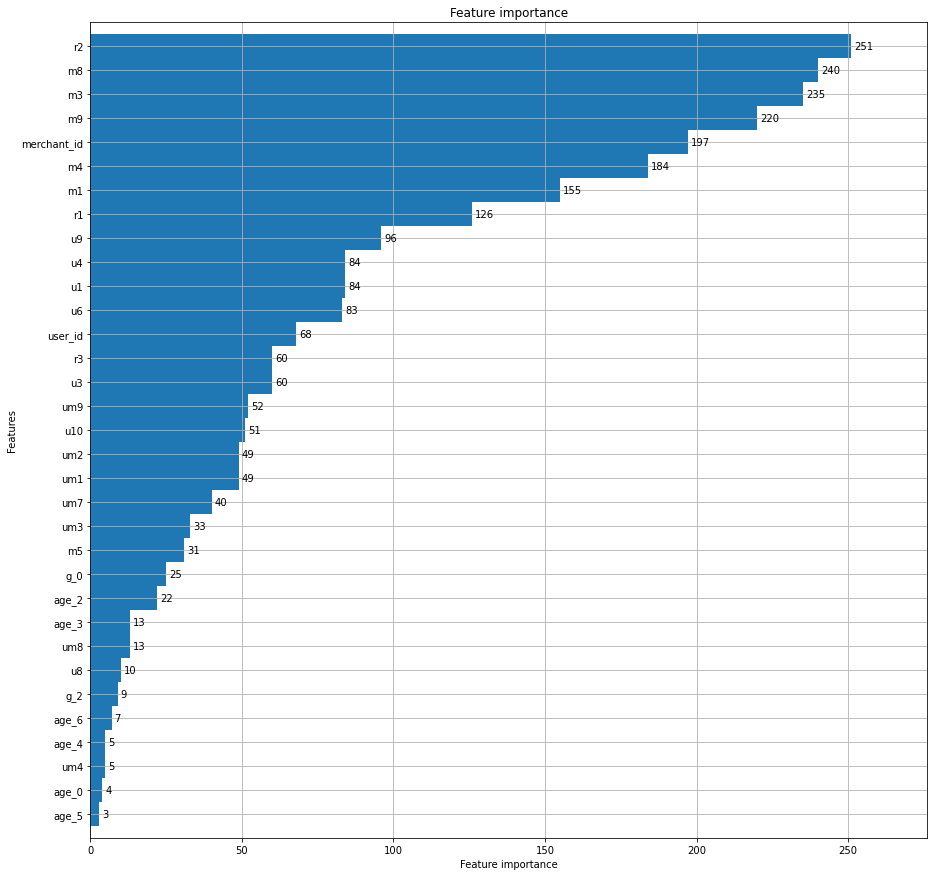

In [96]:
fig, ax = plt.subplots(figsize=(15, 15))
lgb.plot_importance(model_lgb, height=1, ax=ax)

In [97]:
test_data.describe()

,user_id,merchant_id,u1,u3,u4,u6,u8,u9,u10,m1,...,age_1,age_2,age_3,age_4,age_5,age_6,age_7,age_8,g_0,g_2
count,261477.000000,261477.000000,261477.000000,261477.000000,261477.000000,261477.000000,261477.000000,261477.000000,261477.000000,261477.000000,...,261477.000000,261477.000000,261477.000000,261477.000000,261477.000000,261477.000000,261477.000000,261477.000000,261477.000000,261477.000000
mean,212121.259128,2539.620077,143.156450,24.053752,35.590947,145.396976,0.187011,8.791878,7.726309,58866.772018,...,0.000057,0.119930,0.264478,0.196434,0.097959,0.082917,0.016483,0.003048,0.674159,0.041541
std,122480.366678,1451.697856,210.244315,18.083493,36.700412,45.677855,0.921444,10.948551,21.268901,123677.533076,...,0.007574,0.324881,0.441056,0.397301,0.297260,0.275758,0.127325,0.055125,0.468689,0.199538
min,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,391.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,106317.000000,1340.000000,40.000000,11.000000,14.000000,136.000000,0.000000,3.000000,0.000000,7601.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,212289.000000,2482.000000,81.000000,19.000000,25.000000,166.000000,0.000000,6.000000,1.000000,20515.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,318194.000000,3898.000000,165.000000,31.000000,44.000000,174.000000,0.000000,11.000000,6.000000,47979.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,424169.000000,4993.000000,14468.000000,412.000000,1683.000000,184.000000,27.000000,905.000000,1834.000000,730455.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
